# Choosing a baseline model
In this section we discuss what is usually the first stage in tackling an imbalanced classfication problem, namely, to choose a good enough baseline model so further modelling developments are to be compared with this **baseline** model. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## Methodology
We intend to study the behavior (in terms of binary classification metrics) of different classification algorithms under various imbalance scenarios.
At this point we won't pay too much attention on optimizing the model's parameters. Rather, we will work with the vanilla versions of the models as we are interested in finding a "quick" generic approach to solving an imbalanced binary classification problem. 

The classical algorithm used for solving a binary classification problem is the Logistic Regression (citation needed!), two types of regularization (L1 and L2) will be considered to see the effect of regularization in the imbalanced case. On the other hand, it is also common to use tree-based ensemble methods to construct a model for binary classification. Thus, it is natural to consider a couple of Tree ensemble algorithms, such as Random Forests and Gradient Boosting Machines for our experiments. 

Two datasets will be used for the experiments, namely, we will test the algorithms on a synthetic dataset and on a real dataset from which we can sample observations such that the class imbalance ratio can be changed at will. In the following lines we construct a function to generate the synthetic dataset and also load the *real-life* dataset.

In [1]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from typing import Any, List, Dict
from tqdm.auto import tqdm
# from tqdm.notebook import trange, tqdm

# plotting
import matplotlib
from matplotlib import pyplot as plt
# from matplotlib.animation import FuncAnimation


# sklearn
from sklearn.datasets import make_classification

## Data

### Synthetic Dataset (`make_classification`)
We will write a function that generates synthetic binary classification data allowing for various class imbalance levels


In [2]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

Let us have a look at the dataset we have just created:

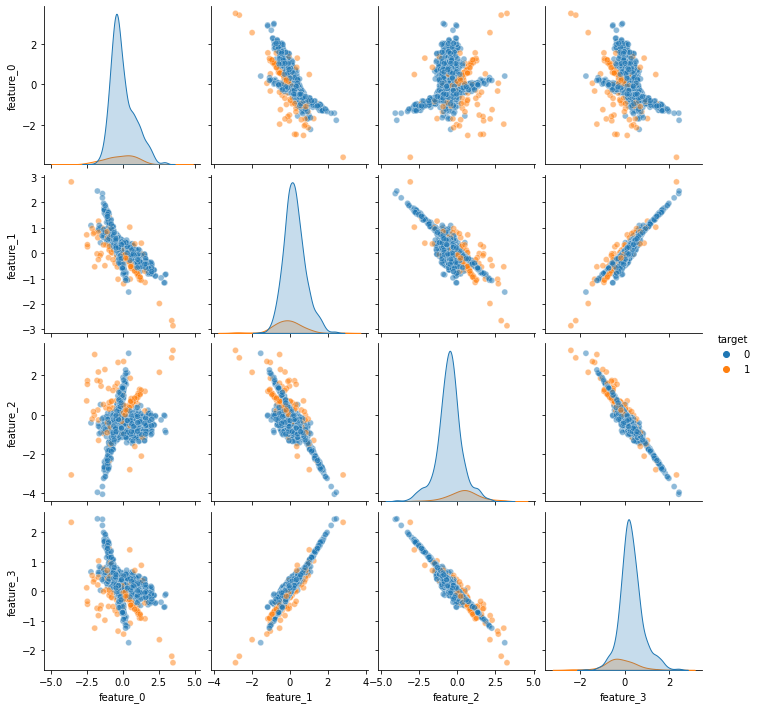

In [4]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})
plt.show()


### Real Life Datasets
In order to validate our experiments with synthetic data, let us collect a couple of *real-life* datasets. The first one is related to a classification taks that asks for predicting whether a subject's income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.
The target is defined as whether the income is greater than $50k. The covariates are (mostly) categorical features related to census data. 

In [55]:
# Census-income dataset
census_df = pd.read_csv('../data/adult.data', header= None)

census_col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', \
                    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', \
                    'native-country']
census_df.columns = census_col_names + ['income']
# encode the target label
census_df['target'] = (census_df.income == ' >50K').astype(int)


In [56]:
census_df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0


Clearly, we will need to pre-process the above dataset before we are able to actually use it for modelling purposes, to that intent we will use the usual sklearn's feature encoding utilities.

In [57]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
census_categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
census_numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [84]:
ohe = OneHotEncoder().fit(census_df[census_categorical_features])
census_ohe = pd.DataFrame(ohe.transform(census_df[census_categorical_features]).toarray(), columns = ohe.get_feature_names_out())

In [86]:
census_df.shape, census_ohe.shape

((32561, 16), (32561, 102))

The second dataset is related to a classification task that asks for predicting if an e-mail is spam or not, based on a very simple text encoding that counts the frequency of appearance of certain words in the e-mail text. 